<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 第五章：在无标签数据上预训练

In [3]:
from importlib.metadata import version

pkgs = [
    "matplotlib",
    "numpy",
    "tiktoken",
    "torch",
    "tensorflow"
]
for p in pkgs:
    try:
        print(f"{p} verison: {version(p)}")
    except ImportError:
        print(f"{p} is not installed")

matplotlib verison: 3.7.5
numpy verison: 1.26.4
tiktoken verison: 0.8.0
torch verison: 2.0.1+cu118
tensorflow is not installed


- 本章节实现训练和评估一个预训练LLM的初步代码
- 结尾也将OpenAI发布的预训练权重加载到本节实现的模型中

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/chapter-overview.webp">
</p>

- 本章节覆盖的主体如下图所示：

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model--0.webp" width=800px>
</p>

## 5.1 评估生成文本模型
- 先使用之前章节中的代码初始化一个GPT模型进行一个简短的回顾
- 然后讨论评价LLMs的基础指标/metrics
- 最后将评价指标应用到训练和测试数据集

### 5.1.1 使用GPT生成文本
- 使用之前的代码初始化一个GPT模型

In [4]:
import torch

from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # 设置为评估模式，关闭dropout

- 上面使用了0.1的dropout，但现在训练LLM时不使用dropout已经相对常见
- 现代的LLM也不在`nn.Linear`层中使用偏置向量（不同于早期的GPT模型），这是通过设置`"qkv_bias": False`实现的
- 将上下文长度(`context_length`)减少到256个token，以减少训练模型的计算资源需求，而原始的124百万参数的GPT-2模型使用了1024个token
  - 这样做是为了让更多的读者能够跟随和执行代码示例，而原始的124百万参数的GPT-2模型使用了1024个token
  - 然而，请随意增加`context_length`到1024个token（这不需要任何代码更改）
  - 稍后也会从预训练权重加载一个1024 `context_length`的模型

- 接下来，使用上一章节的`generate_text_simple`函数生成文本
- 此外，还定义了两个便利函数，`text_to_token_ids`和`token_ids_to_text`，用于在token和文本表示之间进行转换，本章节中会使用它们

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-process.webp" width=800px>
</p>

In [5]:
import tiktoken

from previous_chapters import generate_text_simple


def text_to_token_ids(text: str, tokenizer: tiktoken.Encoding) -> torch.Tensor:
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # 加一个batch维度
    return encoded_tensor


def token_ids_to_text(token_ids: torch.Tensor, tokenizer: tiktoken.Encoding) -> str:
    flat = token_ids.squeeze(0)  # 移除添加的batch维度
    return tokenizer.decode(flat.tolist())


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 如上所见，模型尚未产生良好的文本，这是因为它还没有经过训练
- 如何衡量或捕捉什么是“好的文本”，以数值形式跟踪它，以便在训练过程中测量它？
- 下一小节介绍指标，用于计算生成输出的损失指标，我们可以使用它来衡量训练进度
- 下一章节在微调LLMs时也会介绍其他衡量模型质量的方法

<br>

### 5.1.2 计算文本生成损失：交叉熵和困惑度
- 假设有一个`inputs`张量，其中包含了2个训练样本（行）的词元（token）ID
- 与`inputs`相对应，`targets`包含了希望模型生成的目标词元（token）ID
- 注意`targets`是将`inputs`向后移动1个位置得到的，正如在第2章实现数据加载器时所解释的那样

In [6]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- 将`inputs`输入模型后，获得了2个输入样例的logits向量，每个样例包含3个tokens
- 每个token是一个50,257维的向量，对应词汇表的大小
- 应用softmax函数，可以将logits张量转换为相同维度的张量，其中包含概率分数

In [7]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)  # 词表中每个token的概率
print(probas.shape)  # shape [batch_size, num_tokens, vocab_size]

torch.Size([2, 3, 50257])


- 下图使用了一个非常小的词汇表进行说明，概述了如何将概率分数转换回文本，这是在上一章末尾讨论过的内容

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-to-text.webp" width=800px>
</p>

- 正如在上一章中讨论的，可以应用`argmax`函数将概率分数转换为预测的token ID
- 上面的softmax函数为每个token生成了一个50,257维的向量；`argmax`函数返回这个向量中最高概率分数的位置，即给定token的预测token ID

- 因为输入batch中包含两个样例，每个样例三个tokens，所以得到的token IDs也是相同形状的张量

In [8]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs: \n", token_ids)
print("Shape of token IDs: \n", token_ids.shape)

Token IDs: 
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Shape of token IDs: 
 torch.Size([2, 3, 1])


- 如果解码上述tokens，可能发现其与希望的预测tokens非常不同

In [9]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 这是因为模型还未训练
- 为了训练模型，需要知道预测的结果与正确的结果还相差多远

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-index.webp" width=800px>
</p>

- 目标索引对应的tokens概率如下所示

In [10]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 目标是最大化所有这些值，使它们接近概率1
- 在数学优化中，最大化概率分数本身比最大化概率分数的对数更容易；这在本书的范围内不讨论，下面链接资源详细介绍了这个概念：[L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM)

In [11]:
# 计算所有token概率的对数
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 下一步计算平均对数概率

In [12]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- 目标是使这个平均对数概率尽可能大，通过优化模型权重
- 由于对数，最大可能值是0，而我们目前离0还很远

- 在深度学习中，最大化平均对数概率是标准做法，而不是最小化平均对数概率值；本章节例子中，不是最大化-10.7722，使其接近0，而是最小化10.7722，使其接近0
- 负的-10.7722，即10.7722，在深度学习中也称为交叉熵损失

In [13]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- Pytorch中内部实现了上述计算过程的交叉熵计算函数 `cross_entropy`

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/cross-entropy.webp?123" width=800px>
</p>

- 在应用`cross_entropy`之前，需要检查logits和targets的形状

In [14]:
# Logits的shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets的shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- 对于PyTorch中的`cross_entropy`函数，希望通过在批次维度上合并这些张量来将它们展平

In [15]:
logits_flat = logits.flatten(0, 1)  # 将前两维展平
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- 注意targets是token IDs，也代表了logits张量中希望最大化的token索引位置
- **PyTorch中的`cross_entropy`函数会自动在logits中应用softmax和log-概率计算，内部处理那些需要最大化的token索引位置**

In [16]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- 一个和交叉熵损失相关的概念是LLM的困惑度
- 困惑度是交叉熵损失的指数

In [17]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- 困惑度通常被认为更易于解释，因为它可以被理解为模型在每个步骤中对词汇量（在上述例子中，是48,725个单词或token）的不确定性
- 换句话说，困惑度提供了一个衡量模型预测的概率分布与数据集中单词实际分布之间匹配程度的指标
- 类似地，损失值越低，模型预测越接近实际分布

### 5.1.3 计算训练集和验证机的损失
- 使用一个相对较小的数据集来训练LLM（实际上，只有一篇短故事）
- 原因如下：
  - 可以在没有合适GPU的笔记本电脑上几分钟内运行代码示例
  - 训练相对较快（几分钟而不是几周），这对于教育目的非常有用
  - 使用的是公共领域的文本，可以在不违反任何使用权利或增加仓库大小的情况下包含在GitHub仓库中


- 例如，Llama 2 7B在A100 GPU上训练2万亿个token需要184,320个GPU小时
  - 截至撰写本文时，8xA100云服务器在AWS上的每小时成本约为30美元
  - 因此，通过一个粗略的计算，训练这个LLM将花费184,320 / 8 * 30 = 690,000美元
 
- 下面，使用的是第2章中使用的相同数据集

In [18]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

- 通过打印以及在文本的前后各100个字符作为一个快速检查

In [19]:
print("First 100 characters: ", text_data[:100])
print("Last 100 characters: ", text_data[-100:])

First 100 characters:  I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g
Last 100 characters:   it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [20]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- 5,145个token，文本非常短，不足以训练一个LLM，但再次强调，这是为了教育目的（稍后也会加载预训练权重）

- 接下来，将数据集分为训练集和验证集，并使用第2章中的数据加载器准备LLM训练的批次
- 为了可视化目的，下面的图假设`max_length=6`，但对于训练加载器，将`max_length`设置为LLM支持的上下文长度
- 下面的图只显示输入token，以便于简化
    - 因为训练LLM来预测文本中的下一个词，所以目标看起来与这些输入相同，只是目标向右移动了一个位置

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/batching.webp" width=800px>
</p>

In [21]:
from previous_chapters import create_dataloader_v1

# 训练/验证集的划分
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)
train_loader = create_dataloader_v1(train_data,
                                    batch_size=2,
                                    max_length=GPT_CONFIG_124M["context_length"],
                                    stride=GPT_CONFIG_124M["context_length"],
                                    drop_last=True,
                                    shuffle=True,
                                    num_workers=0)

val_loader = create_dataloader_v1(val_data,
                                  batch_size=2,
                                  max_length=GPT_CONFIG_124M["context_length"],
                                  stride=GPT_CONFIG_124M["context_length"],
                                  drop_last=False,
                                  shuffle=False,
                                  num_workers=0)

In [22]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

- 使用相对较小的批量大小来减少计算资源需求，因为数据集本身很小
- Llama 2 7B训练时使用的批量大小为1024

- 以下是一个可选的检查，确保数据正确加载

In [23]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- 另一个可选的检查是确认token大小在预期的范围内

In [24]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 接下来，实现一个函数来计算给定批次的交叉熵损失
- 此外，实现一个函数来计算数据加载器中用户指定数量的批次的损失

In [28]:
def calc_loss_batch(input_batch: torch.Tensor, target_batch: torch.Tensor,
                    model: torch.nn.Module, device: torch.device) -> torch.Tensor:
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader: torch.utils.data.DataLoader, model: torch.nn.Module,
                     device: torch.device, num_batches: int = None) -> float:
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # 减少批次数量以匹配数据加载器中的总批次数
        # 如果num_batches超过了数据加载器中的批次数量
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        loss = calc_loss_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()
    return total_loss / num_batches

- 如果你有支持CUDA的GPU，LLM将使用GPU训练，而不需要任何代码更改
- 通过`device`设置，确保数据加载到与LLM模型相同的设备上

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 注意:
# 取消注释以下行将允许代码在Apple Silicon芯片上运行，如果适用，这比Apple CPU（在M3 MacBook Air上测量）快约2倍。
# 然而，结果的损失值可能略有不同。

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # 将模型移动到GPU或CPU


torch.manual_seed(123) # 为了可重复性，由于数据加载器中的打乱

with torch.no_grad(): # 为了效率，禁用梯度跟踪，因为还没有训练
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.98110580444336


<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-1.webp" width=800px>
</p>

## 5.2 训练一个LLM
- 本小节实现训练LLM的完整代码
- 主要专注于一个简单的训练函数，如果对使用更高级技术来增强这个训练函数感兴趣，比如学习率预热、余弦退火和梯度裁剪，请参考[Appendix D](../../appendix-D/01_main-chapter-code)

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/train-steps.webp" width=800px>
</p>

In [30]:
from typing import Union, List

import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.optimizer import Optimizer

In [33]:
def evaluate_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                   device: torch.device, eval_iter: int) -> Union[float, float]:
    model.eval()  # 设置验证模式
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model: nn.Module, tokenizer: tiktoken.Encoding, device: torch.device,
                              start_context: str) -> None:
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()


def train_model_simple(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                       optimizer: Optimizer, device: torch.device, num_epochs: int, eval_freq: int,
                       eval_iter: int, start_context: str, tokenizer: tiktoken.Encoding
                       ) -> Union[List[float], List[float], List[int]]:
    # 初始化用于跟踪损失和已见tokens数
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # 主训练循环
    for epoch in range(num_epochs):
        model.train()  # 设置训练模式

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # 清除上一步的损失梯度
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # 计算损失梯度
            optimizer.step()  # 梯度回传更新模型参数
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:  # 开始验证
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        # 在每个epoch最后预测一个输出并打印
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

- 现在开始训练LLM

In [34]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.819, Val loss 9.934
Ep 1 (Step 000005): Train loss 8.065, Val loss 8.340
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.622, Val loss 7.052
Ep 2 (Step 000015): Train loss 6.048, Val loss 6.601
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.591, Val loss 6.479
Ep 3 (Step 000025): Train loss 5.553, Val loss 6.413
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 5.177, Val loss 6.367
Ep 4 (Step 000035): Train loss 4.987, Val loss 6.379
Every effort moves you a a, and a a, and the a, and a. Gisburn, and a, and the of the of the of the a. I had the a, and a. I had the of the a of the of the of
Ep 5 (Step 000040): Train loss 4.351, Val loss 6.276
Every effort moves you, I had been, I had been, I had been a 

- 注意在不同的计算机上可能会得到略有不同的损失值，如果它们大致相似（训练损失低于1，验证损失低于7），则没有必要担心
- 小的差异通常可能是由于不同的GPU硬件和CUDA版本，或者较新PyTorch版本中的微小变化导致的
- 即使在CPU上运行这个示例，也可能会观察到轻微的差异；可能导致差异的一个原因是nn.Dropout在不同操作系统上的行为不同，这取决于PyTorch的编译方式，正如[here on the PyTorch issue tracker](https://github.com/pytorch/pytorch/issues/121595)中讨论的

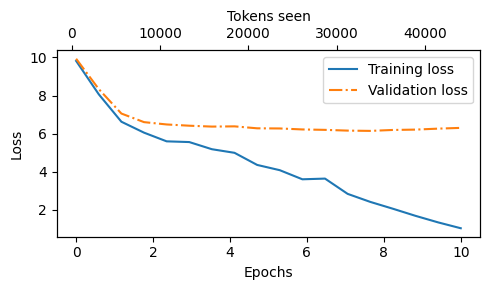

In [35]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen: int, tokens_seen: int, train_losses: List[float], val_losses: List[float]) -> None:
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 从上面的结果可以看到模型最初生成的是难以理解的词语字符串，而到了后期，它能够生成语法上或多或少正确的句子
- 然而，根据训练集和验证集的损失，可以看到模型开始出现过拟合
- 如果检查它在训练结束时写出的几段文字，会发现它们完全照搬自训练集中的内容——模型只是简单地记忆了训练数据
- 稍后将介绍一些解码策略，这些策略可以在一定程度上缓解这种记忆现象
- 注意，这里出现的过拟合是因为训练集非常非常小，而且对它进行了多次迭代
  - 这里的LLM训练主要是出于教育目的，主要想看到模型能够学习生成连贯的文本
  - 不可能花费数周或数月的时间在大量昂贵的硬件上训练这个模型，而是在后面加载预训练权重

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-2.webp" width=800px>
</p>

**如果对使用更高级的技术来增强这个训练函数感兴趣，例如学习率预热、余弦退火和梯度裁剪，请参考[Appendix D](../../appendix-D/01_main-chapter-code)**

**如果对更大的训练数据集和更长时间的训练运行感兴趣，请看靠[../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)**